# Skorch-MNIST

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST Data

In [2]:
mnist = fetch_openml("mnist_784", cache=False)

In [3]:
mnist.data.shape

(70000, 784)

In [4]:
X = mnist.data.astype("float32")
y = mnist.target.astype("int64")

In [5]:
X /= 255.0
X.min(), X.max()

(0.0, 1.0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [7]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

In [8]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

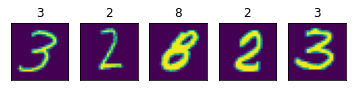

In [9]:
plot_example(X_train, y_train)

# Build NN with PyTorch

In [10]:
import torch
from torch import nn
import torch.nn.functional as F

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim / 8)
output_dim = len(np.unique(mnist.target))
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

In [13]:
class ClassifierModule(nn.Module):
    def __init__(
        self,
        input_dim=mnist_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

In [14]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

In [15]:
from sklearn.metrics import accuracy_score

acc = EpochScoring(accuracy_score)

In [16]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule, max_epochs=20, lr=0.1, device=device, callbacks=[acc]
)

- Seems all metrics are on validation set
- How to get it from train set?

In [17]:
net.fit(X_train, y_train)

  epoch    accuracy_score    train_loss    valid_acc    valid_loss     dur
-------  ----------------  ------------  -----------  ------------  ------
      1            0.8876        0.8297       0.8876        0.4013  0.9314
      2            0.9121        0.4352       0.9121        0.3075  0.9280
      3            0.9218        0.3653       0.9218        0.2698  0.9405
      4            0.9312        0.3223       0.9312        0.2350  0.9490
      5            0.9348        0.2953       0.9348        0.2216  0.9479
      6            0.9409        0.2705       0.9409        0.2006  0.9514
      7            0.9439        0.2575       0.9439        0.1872  0.9567
      8            0.9466        0.2443       0.9466        0.1796  0.9469
      9            0.9510        0.2315       0.9510        0.1673  0.9452
     10            0.9532        0.2245       0.9532        0.1617  0.9449
     11            0.9543        0.2124       0.9543        0.1556  0.9442
     12            0.9552

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dropout): Dropout(p=0.5, inplace=False)
    (hidden): Linear(in_features=784, out_features=98, bias=True)
    (output): Linear(in_features=98, out_features=10, bias=True)
  ),
)

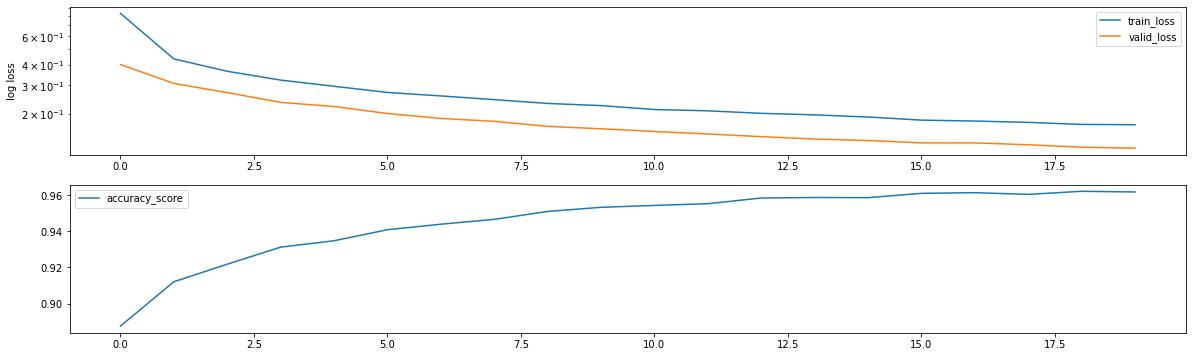

In [18]:
plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(net.history[:, "train_loss"], label="train_loss")
plt.plot(net.history[:, "valid_loss"], label="valid_loss")
plt.yscale("log")
plt.ylabel("log loss")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(net.history[:, "accuracy_score"], label="accuracy_score")
plt.legend()
plt.show()

# CNN

In [19]:
XCnn = X.reshape(-1, 1, 28, 28)
Xcnn.shape

In [20]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(
    XCnn, y, test_size=0.25, random_state=42
)

In [21]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100)  # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [22]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
    callbacks=[acc],
)

In [23]:
cnn.fit(XCnn_train, y_train);

  epoch    accuracy_score    train_loss    valid_acc    valid_loss     dur
-------  ----------------  ------------  -----------  ------------  ------
      1            0.9717        0.4371       0.9717        0.0952  1.5752
      2            0.9789        0.1708       0.9789        0.0676  1.5557
      3            0.9805        0.1360       0.9805        0.0613  1.5290
      4            0.9841        0.1125       0.9841        0.0504  1.5159
      5            0.9856        0.1091       0.9856        0.0466  1.4986
      6            0.9857        0.1012       0.9857        0.0451  1.5337
      7            0.9864        0.0934       0.9864        0.0451  1.5011
      8            0.9870        0.0861       0.9870        0.0415  1.5231
      9            0.9873        0.0827       0.9873        0.0382  1.5325
     10            0.9873        0.0773       0.9873        0.0387  1.5309


In [24]:
y_pred_cnn = cnn.predict(XCnn_test)

In [25]:
accuracy_score(y_test, y_pred_cnn)

0.9878857142857143

In [26]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

NameError: name 'error_mask' is not defined